<a href="https://colab.research.google.com/github/Fnriquel/Fabian_Project/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bert Fine tunned with ABC Dataset

# Loading Data sets and packages

In [102]:
!pip install -q sentencepiece
!pip install -q transformers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import BertTokenizer, TFBertModel, DataCollatorForLanguageModeling

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
data_path = "/content/drive/My Drive/w266/data_02.csv"
data = pd.read_csv(data_path)

In [105]:
type(data)

pandas.core.frame.DataFrame

# Pre-process data for task

In [128]:
data = data.dropna(subset=["assembly_name", "part_names"])
data = data.drop(columns=["assembly_id"]) #, 'part_names'])
data.head()

,assembly_name,assembly_description,part_names
0,Lava Lamp 2,NaN,"['Blob3', 'Blob2', 'Blob1', 'Glass', 'Cap']"
1,Sample - Headphones,NaN,"['Pivot hinge', 'Headphone hinge', 'Telescope ..."
4,Coffee Mug,NaN,"['Mug', 'Lid']"
5,Dave's Handsome Mug,NaN,"['Lid', 'Seal', 'Vessel']"
9,Mechanical Pencil,NaN,"['Eraser', 'Pencil Lead', 'Rubber Grip', 'Grip..."


In [129]:
# Deduplicate
print(f"Tot before dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot before dedup: 88886
Unique: 67834
After dedup: 61725
Unique: 54034


In [130]:
counts = Counter(data['assembly_name'])
#counts.most_common()[:100]

In [131]:
import re
def process_string3(string):

    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = string.replace('.dwg', '')
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_string3(row.assembly_name), axis=1)
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")
data=data[data['assembly_name_clean']!='untitled document']
data=data[data['assembly_name_clean']!='test']
print(f"After dropping some rows: {len(data['assembly_name_clean'].unique())}")
counts = Counter(data['assembly_name_clean'])
counts.most_common()[:100]

After dedup: 61725
Unique: 49644
After dropping some rows: 49642


[('farm bot genesis', 277),
 ('onshape instructor kit 4.2.2 creating and adding subassemblies', 197),
 ('eez ybot arm mk2', 169),
 ('perrinn f aero', 135),
 ('tutorial 1 onshape tour', 110),
 ('smartrap core base smartfriendz', 87),
 ('perrinn lmp', 82),
 ('box', 78),
 ('robot', 66),
 ('3d printer', 57),
 ('p', 50),
 ('cnc', 49),
 ('violin', 48),
 ('table', 45),
 ('college week 4', 45),
 ('spinner', 45),
 ('house', 44),
 ('spool holder', 42),
 ('desk', 41),
 ('poppy humanoid v1.0.1', 41),
 ('wheel grinder', 39),
 ('prusa i mk2 by toto g', 39),
 ('aerofoil script', 39),
 ('my mechanical project', 39),
 ('concept vehicle', 38),
 ('frame', 37),
 ('evezor robotic arm', 36),
 ('case', 34),
 ('drawing machine', 32),
 ('workbench', 31),
 ('clock', 29),
 ('scooter', 29),
 ('perrinn f 2016', 28),
 ('perrinn f', 28),
 ('m', 27),
 ('gear', 27),
 ('official smartrap core smartfriendz', 27),
 ('bullet feeder', 27),
 ('sample engine', 25),
 ('assembly', 25),
 ('g helmet electronics mount public', 24

# Clean Part Names

In [132]:
data

,assembly_name,assembly_description,part_names,assembly_name_clean
0,Lava Lamp 2,NaN,"['Blob3', 'Blob2', 'Blob1', 'Glass', 'Cap']",lava lamp 2
1,Sample - Headphones,NaN,"['Pivot hinge', 'Headphone hinge', 'Telescope ...",sample headphones
4,Coffee Mug,NaN,"['Mug', 'Lid']",coffee mug
5,Dave's Handsome Mug,NaN,"['Lid', 'Seal', 'Vessel']",dave's handsome mug
9,Mechanical Pencil,NaN,"['Eraser', 'Pencil Lead', 'Rubber Grip', 'Grip...",mechanical pencil
...,...,...,...,...
456776,Luke,NaN,['Luke tag'],luke
456777,Dry Box,NaN,"['Mount', 'Rod']",dry box
456788,2017-2018 9889,NaN,"['WHEEL-HUB-IN-L', 'WHEEL-HUB-OUT-R', 'WHEEL-H...",2017 2018 9889
456792,Table,NaN,"['Leg 350x850', 'Pin', 'Leg 310x850']",table


In [125]:
def process_string(string):
    string = string.lower()
    string = string.replace('_', '')
    string = string.replace('-', '')
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace("'", '')
    string= string.split(',')
    return string

def process_string2(string):
    string = string.lower()
    string = string.replace('_', '')
    string = string.replace('-', '')
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace('(', '')
    string = string.replace(')', '')
    string = string.replace("'", '')
    string= string.split(" ")
    return string


In [133]:
strings = []
labels = []
for index, row in tqdm(data.iterrows(), total=len(data)):
  string_split = process_string(str(row['part_names']))
  if len(string_split) > 0:
    if pd.isna(row['assembly_description'])==False:
        phrase = f"The assembly description is '{row['assembly_description']}' has the following parts: "
        for part_name in string_split:
            phrase += f"{part_name}, "
        #print(phrase)
    else:
        phrase = f"there are the following parts: "
        for part_name in string_split:
            phrase += f"{part_name}, "
    strings.append(phrase)
    labels.append(process_string2(row['assembly_name'])[0])
    


100%|██████████| 60278/60278 [00:04<00:00, 13221.41it/s]


In [134]:
labels[:10]

['lava',
 'sample',
 'coffee',
 'daves',
 'mechanical',
 'os',
 'torch',
 'bottle',
 'concept',
 'mounting']

In [135]:
type(labels)

list

In [136]:
from collections import Counter
  
def unique(list1):
  
    # Print directly by using * symbol
    return(len(Counter(list1)))

unique(labels)/len(labels)

0.5216330999701384

In [137]:
print(unique(labels))
print(len(strings))

31443
60278


In [138]:
my_dict = {}
i=0
for item in labels:
    if item not in my_dict:
        my_dict[item] = i
        i+=1

print(my_dict)

{'lava': 0, 'sample': 1, 'coffee': 2, 'daves': 3, 'mechanical': 4, 'os': 5, 'torch': 6, 'bottle': 7, 'concept': 8, 'mounting': 9, 'home': 10, 'autoturret.xt': 11, 'robot': 12, 'main': 13, 'case': 14, 'weldment2': 15, 'compass': 16, 'veco': 17, 'automated': 18, 'mec000992er.sldprt': 19, 'ibeam.stp': 20, '3d': 21, 'boat': 22, 'cylinder': 23, 'clamp': 24, 'scanner': 25, 'assembled': 26, 'sumitomo': 27, 'hard': 28, 'halloweenmachine': 29, 'motw': 30, 'hexapod': 31, 'composite': 32, '18700': 33, 'casting': 34, 'custom': 35, '26650': 36, 'independent': 37, 'resync': 38, 'bellroller': 39, 'tutorial': 40, 'mechanism': 41, 'onshapeit': 42, 'box': 43, 'quadro': 44, 'dlogger': 45, 'level': 46, 'knob,': 47, 'camera': 48, 'am1': 49, '6axis': 50, 'three': 51, 'tablet': 52, '25100w.stp': 53, 'gumdrop': 54, 'cc': 55, 'tiny': 56, 'crankpiston': 57, 'fixtures': 58, 'sawsall': 59, 'thermostat': 60, 'fasteners': 61, 'logo': 62, 'lightweight': 63, 'motorcycle': 64, 'light': 65, 'classic': 66, '37': 67, 'fl

In [139]:
labels_2=list(my_dict.keys())

In [140]:
labels_2

['lava',
 'sample',
 'coffee',
 'daves',
 'mechanical',
 'os',
 'torch',
 'bottle',
 'concept',
 'mounting',
 'home',
 'autoturret.xt',
 'robot',
 'main',
 'case',
 'weldment2',
 'compass',
 'veco',
 'automated',
 'mec000992er.sldprt',
 'ibeam.stp',
 '3d',
 'boat',
 'cylinder',
 'clamp',
 'scanner',
 'assembled',
 'sumitomo',
 'hard',
 'halloweenmachine',
 'motw',
 'hexapod',
 'composite',
 '18700',
 'casting',
 'custom',
 '26650',
 'independent',
 'resync',
 'bellroller',
 'tutorial',
 'mechanism',
 'onshapeit',
 'box',
 'quadro',
 'dlogger',
 'level',
 'knob,',
 'camera',
 'am1',
 '6axis',
 'three',
 'tablet',
 '25100w.stp',
 'gumdrop',
 'cc',
 'tiny',
 'crankpiston',
 'fixtures',
 'sawsall',
 'thermostat',
 'fasteners',
 'logo',
 'lightweight',
 'motorcycle',
 'light',
 'classic',
 '37',
 'flag',
 'picture',
 'bellringer',
 'venturio',
 'skateboard',
 'dragoon',
 'gravity',
 'metal',
 'bike',
 'archery',
 'polyhedrons',
 'pd',
 'hub',
 'horloge',
 'big',
 'copy',
 'gas',
 'tähtiträk

In [141]:
strings[100:180]

['there are the following parts: rhombic dodecahedron,  rhombic triacontahedron,  dodecahedron,  icosahedron, ',
 'there are the following parts: wheel,  lead weight,  nail, ',
 'there are the following parts: cage,  stud4,  stud3,  stud2,  seal,  innerrace,  innerrace,  stud1,  hub, ',
 'there are the following parts: contours cadran,  cadran,  axemoteur,  moteur,  dalle eink,  contours cadran,  \\\\x2\\\\00c9\\\\x0\\\\cran eink,  roue 4,  roue 3,  roue 2,  roue 1, ',
 'there are the following parts: 4x4x96,  4x4x102,  4x4x96,  mini child 3,  mini child 2,  mini child 1,  side deck,  child 3,  child 2,  child 1,  upper deck,  mini child 3,  mini child 2,  mini child 1,  child 4,  child 3,  child 2,  child 1,  upper deck,  lower deck,  child 6,  child 5,  child 4,  child 3,  child 2,  child 1,  wall 7,  wall 8,  short wall support,  wall support,  wall 6,  wall 1 entry,  wall 5,  wall 4,  wall 3,  wall 2,  wall 1, ',
 'there are the following parts: lower link,  bushing,  rockerlhs,  r

In [ ]:
#from collections import OrderedDict
#train_label_index=[]
#unique_labels=list(OrderedDict.fromkeys(labels).keys())


#for i in range(0,len(unique_labels)):
  #train_label_index.append(i)


# K-Means Labels

In [ ]:
!pip install levenshtein

In [154]:
len(labels_2)

31443

In [2]:
words = labels_2[0:20000]


NameError: ignored

In [156]:
words

['lava',
 'sample',
 'coffee',
 'daves',
 'mechanical',
 'os',
 'torch',
 'bottle',
 'concept',
 'mounting',
 'home',
 'autoturret.xt',
 'robot',
 'main',
 'case',
 'weldment2',
 'compass',
 'veco',
 'automated',
 'mec000992er.sldprt',
 'ibeam.stp',
 '3d',
 'boat',
 'cylinder',
 'clamp',
 'scanner',
 'assembled',
 'sumitomo',
 'hard',
 'halloweenmachine',
 'motw',
 'hexapod',
 'composite',
 '18700',
 'casting',
 'custom',
 '26650',
 'independent',
 'resync',
 'bellroller',
 'tutorial',
 'mechanism',
 'onshapeit',
 'box',
 'quadro',
 'dlogger',
 'level',
 'knob,',
 'camera',
 'am1',
 '6axis',
 'three',
 'tablet',
 '25100w.stp',
 'gumdrop',
 'cc',
 'tiny',
 'crankpiston',
 'fixtures',
 'sawsall',
 'thermostat',
 'fasteners',
 'logo',
 'lightweight',
 'motorcycle',
 'light',
 'classic',
 '37',
 'flag',
 'picture',
 'bellringer',
 'venturio',
 'skateboard',
 'dragoon',
 'gravity',
 'metal',
 'bike',
 'archery',
 'polyhedrons',
 'pd',
 'hub',
 'horloge',
 'big',
 'copy',
 'gas',
 'tähtiträk

In [ ]:
import numpy as np
from sklearn.cluster import AffinityPropagation
from Levenshtein import distance
    

words = np.asarray(words) #So that indexing with a list will work
lev_similarity = -1*np.array([[distance(w1,w2) for w1 in words] for w2 in words])



In [1]:
lev_similarity.shape

NameError: ignored

In [79]:
affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(lev_similarity)

AffinityPropagation(affinity='precomputed')

In [80]:
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *sample:* apple, dynamixel, examples, paddle, sample, sharpener, skaphylle, spamalot, stuhl, timepiece
 - *bottle:* bookbottom, bottle, bouteille, button, cottage, doubled, little, mophie, nozzle, skittle, ukulele, untitled, whistle
 - *autoturret.xt:* autoturret.xt
 - *robot:* drobnosti, icdbot, irobothome, kirppubot, lulzbot, monobox, oggi, omnibot, prototype, robo3d, robot, robotic, roverbot, zobrati
 - *mec000992er.sldprt:* mec000992er.sldprt
 - *halloweenmachine:* halloweenmachine
 - *tutorial:* aquaponics, ottoman, pantograph, pultgriff, sottoscala, structural, tutorial, tutorials, vectornav
 - *quadro:* cilindros, dualzrobo, filtro, gumdrop, isodéco, laundry, quad2, quadbarrel, quadbike1, quadcopter, quadrevo, quadro, quadruped, teardrop, zrcadlo
 - *tablet:* cable, candles, catapult, gabarito, gauntlet, lambchop, magnet, magnetic, table, tablebot, tablet, turret, usbdelec
 - *crankpiston:* clearvision, crankpiston, organization
 - *light:* 2night.it, bigqr, camera/light, fir

# Train and Test

In [142]:
train_strings, test_strings, train_labels, test_labels = train_test_split(strings,labels, test_size=0.2)
print(f"Length of train: {len(train_strings)}")
print(f"Length of test: {len(test_strings)}")
print(f"Length of train: {len(train_labels)}")
print(f"Length of train: {len(test_labels)}")

Length of train: 48222
Length of test: 12056
Length of train: 48222
Length of train: 12056


#Creating Bert Model

In [143]:
max_length = 128
model_checkpoint = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [144]:
from collections import OrderedDict
train_label_index=[]
test_label_index=[]
for item in train_labels:
  train_label_index.append(my_dict[item])

for i in test_labels:
  test_label_index.append(my_dict[item])    


In [145]:
len(list(OrderedDict.fromkeys(train_labels).keys()))

26237

In [146]:
len(train_label_index)

48222

In [147]:
len(train_labels)

48222

In [148]:
# BERT Tokenization of training and test data

num_train_examples = 40000      # set number of train examples - 1500 for realtime demo
num_test_examples = 10000        # set number of test examples - 500 for realtime demo

max_length = 128                 # set max_length

all_train_examples = train_strings
all_test_examples = test_strings

y_train =  tf.convert_to_tensor(train_label_index[:num_train_examples])
              
x_train = bert_tokenizer(all_train_examples[:num_train_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

              

y_test =  tf.convert_to_tensor(test_label_index[:num_test_examples])
x_test = bert_tokenizer(all_test_examples[:num_test_examples],
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')


In [149]:
def create_bert_classification_model(bert_model,
                                     train_layers=-1,
                                     hidden_size = 200, 
                                     dropout=0.3,
                                     learning_rate=0.0001):
    """
    Build a simple classification model with BERT. Use the Pooled Output for classification purposes
    """
    
    bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooled_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


    hidden = tf.keras.layers.Dropout(dropout)(hidden)  


    classification = tf.keras.layers.Dense(36279, activation='softmax',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                 metrics='accuracy')

    
    return classification_model

In [150]:
bert_classification_model = create_bert_classification_model(bert_model)

In [151]:
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

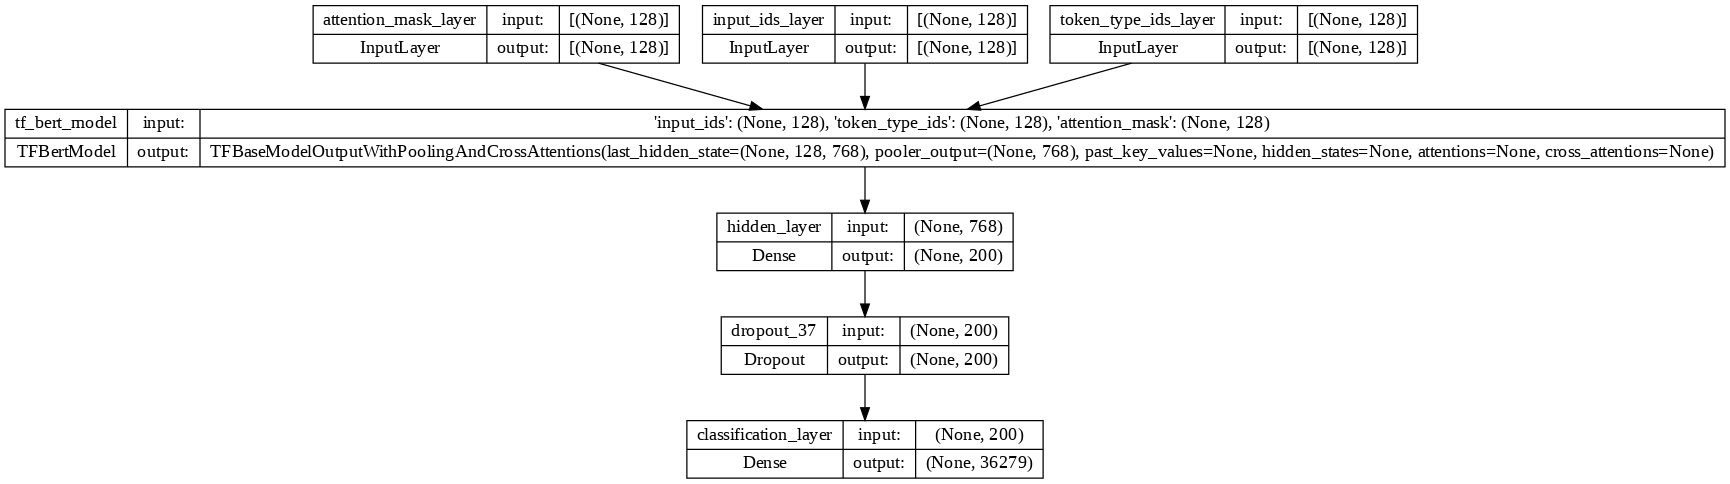

In [152]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [153]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], y_test),
    batch_size=32,
    epochs=2
)  

Epoch 1/2
1250/1250 [==============================] - 1055s 836ms/step - loss: 10.0004 - accuracy: 0.0052 - val_loss: 11.3469 - val_accuracy: 0.0000e+00
Epoch 2/2
 206/1250 [===>..........................] - ETA: 13:22 - loss: 9.5692 - accuracy: 0.0058

KeyboardInterrupt: ignored